In [6]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
from monai.losses import DiceCELoss

# include project src in path
sys.path.append(os.path.abspath("../src/inference"))
from inference import run_inference, evaluate, ensemble_inference
sys.path.append(os.path.abspath("../src"))
from utils.visualization import visualize_slices
import torch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = "../results/exp24_nnunet/fold2/checkpoints/best.ckpt"
OUTPUT_DIR     = "../results/inference"
BATCH_SIZE     = 3
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")  

In [8]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    weight=torch.tensor([0.4,1.7,1.5]).to(DEVICE),
    lambda_dice=0.5, lambda_ce=0.5
)

In [9]:
# Single model
model, loader = run_inference(DATA_DIR, CHECKPOINT, OUTPUT_DIR, BATCH_SIZE, MODEL_TYPE, DEVICE)
metrics = evaluate(model, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Inference: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


Inference done; outputs in ../results/inference


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.33it/s]

avg_loss: 0.3461
mean_dice: 0.7091
dice_class1: 0.8668
dice_class2: 0.5514
prec_class1: 0.5604
recall_class1: 0.6719
prec_class2: 0.5813
recall_class2: 0.5270


In [10]:
# Ensemble
CKPT_GLOB = "../results/exp24_nnunet/fold*/checkpoints/best.ckpt"
OUT_ENS   = "../results/inference/ensemble"

# run inference and grab model + loader
models, loader = ensemble_inference(DATA_DIR, OUT_ENS, CKPT_GLOB, MODEL_TYPE, BATCH_SIZE, DEVICE)
metrics_ens = evaluate(models, loader, loss_fn, DEVICE)
# print the metrics
for key, value in metrics_ens.items():
    print(f"{key}: {value:.4f}")

Ensemble Inference: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Ensembled predictions saved to ../results/inference/ensemble


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

avg_loss: 0.3290
mean_dice: 0.6884
dice_class1: 0.8771
dice_class2: 0.4997
prec_class1: 0.6820
recall_class1: 0.6679
prec_class2: 0.7347
recall_class2: 0.4719


Label class distribution: (1738493, 22930, 8049)
Prediction class distribution: (1748901, 5225, 15346)


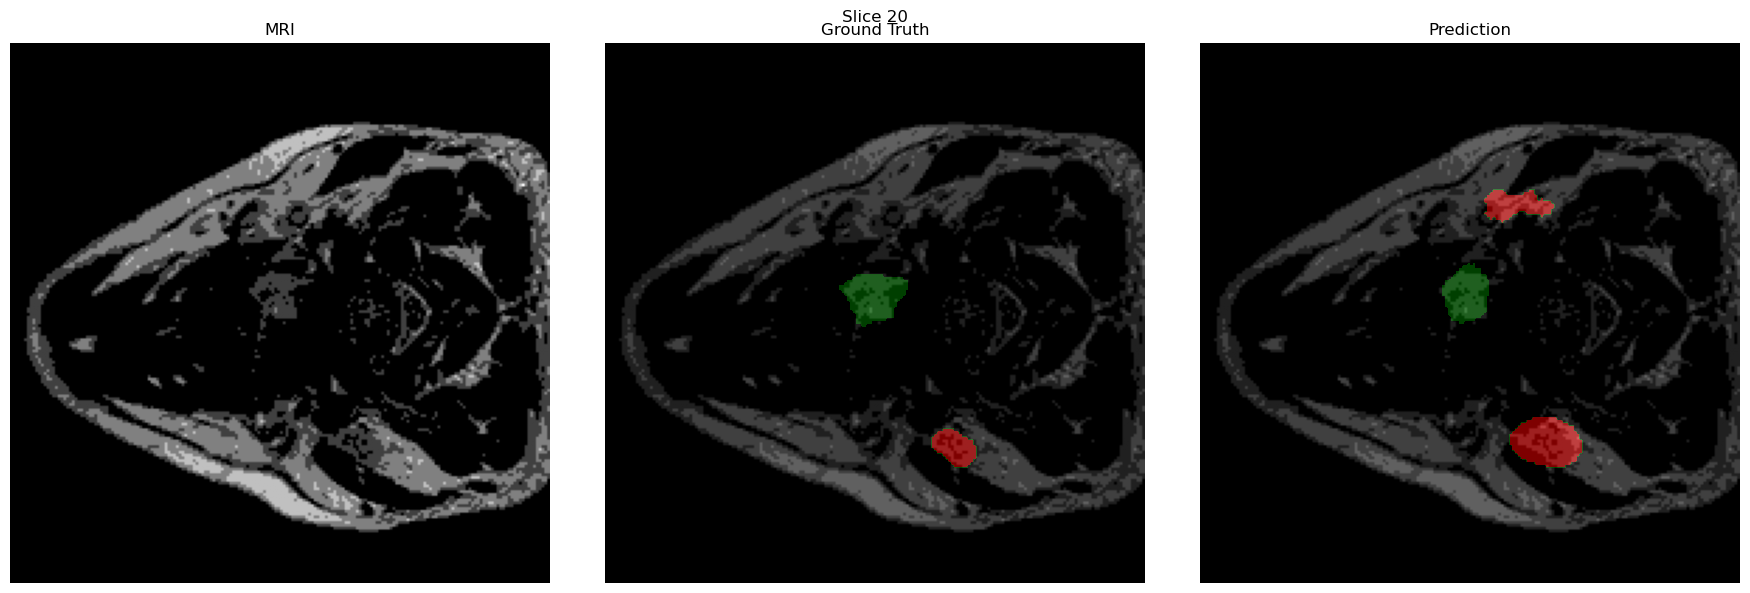

In [11]:
# Visualize
visualize_slices(f"{OUTPUT_DIR}/image_3.nii.gz",
                 f"{OUTPUT_DIR}/label_3.nii.gz",
                 f"{OUTPUT_DIR}/prediction_3.nii.gz", slice_idx=20)
